In [1]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
%matplotlib widget

# If you are using Jupyter Notebook
# %matplotlib notebook

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Exercise 4: Gait Analysis

Normally we have an measurement exercise as part of biosig, where we record some data together.
One of the signals we record are gait signals recorded with small IMUs attached to both feet.

In this exercise we will do some event detection based on such a signal.
Because we could not record data this year because of COVID, I provided you with an example data from last year.
This data contains a *4x10m* gait test.
In this test, subjects are asked to walk back and forth a 10m distance 4 times.
This is a typical clinical test performed to asses patients ability to walk.
In instrumented version of this test (with IMUs) gait parameters are calculated on a stride level and then the mean and the CV over the entire test is provided to the doctor.

Most parameters that are calculated from such tests are either temporal (Describing the duration of a stride or subphases) or spatial (describing the position, or orientation of the foot during a stride).
The calculation of spatial parameters is often complicated and requires complicated filter systems, physical models, or machine learning systems that require a large amounts of training data.
Therefore, today's exercise will focus on the temporal parameters.
More specifically we will calculate the stride time and the swing time for each participant.

## Exercise 4.1: Stride Segmentation

The first step of our pipeline is concerned with the detection of individual strides in our raw sensor signal.
Various algorithms have been published to achieve this task.
Some of them use complex mathematical models like *Hidden Markov Models* or Deep Learning.
However, a simple peak detection can provide usable results in many cases.

To find strides requires to define the start and stop event.
We won't use any "meaningful" event during the gait cycle, but an event we can easily detect in the signal.
We will use a similar definition to the one used by Rampp et al. in their 2015 publication (see Image below)

![gait signal](media/gait_signals.png)

a) Load one of the csv files in the data folder (Tip: do **not** use `99430_right` for now) and plot the signal. All data is recorded with 102.4 Hz. Can you identify the signals from the image above?

b) The `gyr_z` axis provides easy to identify (negative) peaks that can be used as the start and stop event of individual strides (dotted lines in the image above). Use your knowledge from the last exercises to create a peak detector to identify these peaks.
It might be impossible to find all peaks correctly.

c) Draw vertical lines for each peak in the visualization you created above.

d) Test your peak detection with at least one other file. And change your parameter if needed.

In [2]:
# Load the data and store it in the variable data
# Plot the data to understand the signal
### BEGIN SOLUTION
data = pd.read_csv('./data/87b6d_right.csv').set_index('n_samples')
### END SOLUTION

In [3]:
# Create the following function to identify stride borders
from scipy.signal import find_peaks

def find_stride_borders(data):
    """Find stride borders in a continuous IMU signal.
    
    Args:
        data: pandas dataframe with various columns
    
    Returns:
        borders: np.array with the index values of the stride borders
    """
    ### BEGIN SOLUTION
    borders, _ = find_peaks(-data['gyr_z'], height=200, distance=100)
    ### END SOLUTION
    return borders

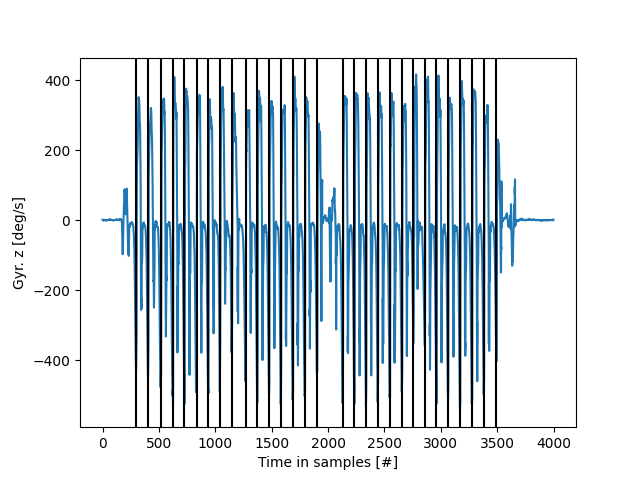

In [4]:
stride_borders = find_stride_borders(data)

# Plot the gyr_z signal together with the stride borders
### BEGIN SOLUTION
plt.figure()
plt.plot(data['gyr_z'])
for border in stride_borders:
    plt.axvline(border, c='k')
### END SOLUTION
plt.xlabel('Time in samples [#]')
plt.ylabel('Gyr. z [deg/s]');

## Exercise 4.2: Defining Strides and Outlier Detection

Based on the stride borders we can now define actual strides as the region between two consecutive borders.
However, sometimes our peak detection might miss a stride or our subject performed other movements between two stride borders.
In these cases we do not want to mark this region as a stride.
Therefore, we will remove detected strides, if their duration is too different from the rest of the strides.

a) Turn the list of stride borders into a 2D-array, where each line contains the start and the stop of an individual stride.

b) Below you can find a function that removes outlier from the data. All strides which duration is outside two standard deviations from the **median** of all strides are removed. Apply this function to your stride list.

c) Use the provided `plot_strides` function to plot the stride list before and after the outlier removal.
Use `plt.subplots` to plot both graphs directly below each other.
Which strides were removed? Is this in line with your expectations? 

### Solution:

c) The outlier removal should correctly find and remove cases were the peak detection missed one or multiple stride borders.
Further, it might remove turnings, if they were performed slower than a normal stride.

In [5]:
def plot_strides(data, strides, ax=None):
    """Plot your data with the strides overlayed.
    
    Args:
        data: np.array or pd.DataFrame/Series
        strides: 2D array with start and stop index of each stride
        ax: An optional matplotlib axes instance to plot into. If `None` a new figure is created.
    """
    if not ax:
        plt.figure()
        ax = plt.gca()
    ax.plot(data)
    for start, stop in strides:
        ax.axvline(start, c='k')
        ax.axvline(stop, c='k')
        ax.axvspan(start, stop, alpha=0.2)

In [6]:
# create a 2D-array called strides, where each line contains the start and the stop of an individual stride
### BEGIN SOLUTION
strides = np.array(list(zip(stride_borders[:-1], stride_borders[1:])))
### END SOLUTION

In [7]:
# Create a function to perform the outlier removal
def outlier_removal(strides):
    """Remove outlier based on median and STD.
    
    Args:
        strides: 2D array with start and stop index of each stride
    
    Returns:
        cleaned_stride_list: same as strides, but with outliers removes
    """
    # Calculate the duration of each stride
    stride_time = np.diff(strides, axis=1).reshape(-1)
    # Calculate the median and the std of the stride duration
    median = np.median(stride_time)
    std = np.std(stride_time)
    # Create a new version of the stride list that does not contain
    # any strides with a duration smaller than median - 2 * STD or
    # larger than median +2 * STD 
    outlier = (stride_time < median - 2*std) | (stride_time >  median + 2*std)
    cleaned_stride_list = strides[~outlier]
    return cleaned_stride_list

# Remove the outliers
### BEGIN SOLUTION
cleaned_strides = outlier_removal(strides)
### END SOLUTION

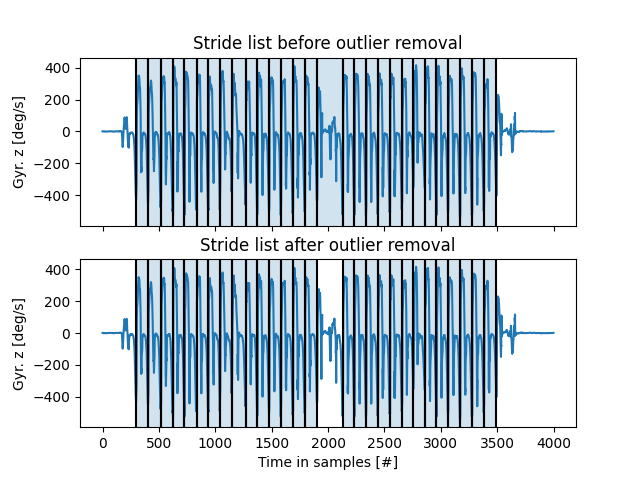

In [8]:
# Plot the results using the `plot_strides` function
# Use subplots with shared x-axis to plot the original strides in the top plot
# and the result of the outlier removal in the lower plot.
# Set titles for each subplots
### BEGIN SOLUTION
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
plot_strides(data['gyr_z'], strides, ax=ax1)
ax1.set_ylabel('Gyr. z [deg/s]')
ax1.set_title('Stride list before outlier removal')
plot_strides(data['gyr_z'], cleaned_strides, ax=ax2)
ax2.set_title('Stride list after outlier removal')
ax2.set_ylabel('Gyr. z [deg/s]')
### END SOLUTION
plt.xlabel('Time in samples [#]');

## Exercise 4.3: Event Detection

With the stride list, we can already calculate the *stride time*.
But for the *swing time* we need to look into each stride and identify two important events: the heel strike (HS) and the toe off (TO).

a) Have a look at the paper by Rampp et al. to better understand what the HS and the TO are.

b) Read the section about Gait Event detection (*D. Calculation of Gait Parameters,  1)*) and implement the described HS detection with the following two modifications: 

   - Skip the detection of the steepest slope and search for the minima in the entire region
   - Use a search window of -80 ms to +50 ms instead of -50 ms to +20 ms.
 
   Because the sampling rate is $\approx$ 100 hz you can use 8 and 5 samples for the search region.

c) below you will also find a function that can find the TO. Apply it to your data as well. Have a look at the function and try to understand how `np.argmax(np.diff(np.sign(gyr)))` can provide the first zero crossings of a signal. Why is the 0-crossing not always on the 0-line?
  
d) Plot the identified events using the same marker as Rampp et al.. Do the events appear in the correct regions of the signal?

### Solution:

c)
`np.sign` provides the sign so (1 or -1) of the signal for each signal. Using `np.diff` we can find the sample by sample change. This means wehen ever we havea change in sign we get +2 or -2. Finally, `np.argmax` provides us the first occurance of the maximum (+2) in the signal, which is our first 0 crossing.
Note, that this implementation is not efficient or easy to read, but simply convenient.

Most of the TO events are not on the 0-line.
This is strange, as we specifically searched for zero crossings.
However, the sampling rate is not high enough to always sample the exact point in time.



In [9]:
# HS Event

def find_hs(stride_data):
    """Find the HS event in the raw signal of one stride
    
    Args:
        stride_data: pd.DataFrame containing the IMU data of a single stride
    
    Returns:
        to_event: Index of the HS event within the provided stride
    """
    gyr = stride_data['gyr_z'].values
    acc = stride_data['acc_x'].values
    # Extract the region between the gyro max and the middle of the stride
    ### BEGIN SOLUTION
    global_gyr_max = np.argmax(gyr)
    roi_gyr = gyr[global_gyr_max:len(gyr) // 2]
    ### END SOLUTION
    # Handle the situation where this region is 0 samples long.
    # Return np.nan in this case
    ### BEGIN SOLUTION
    if not len(roi_gyr):
        return np.nan
    ### END SOLUTION
    # Identify the search window based on the gyro min
    ### BEGIN SOLUTION
    gyr_min = global_gyr_max + np.argmin(roi_gyr)
    roi_acc_start = gyr_min - 8
    roi_acc_stop = gyr_min + 5
    ### END SOLUTION
    # Extract the acc signal in the search window and find the minima
    ### BEGIN SOLUTION
    roi_acc = acc[roi_acc_start: roi_acc_stop]
    hs_event = roi_acc_start + np.argmin(roi_acc) 
    ### END SOLUTION
    return hs_event

# TO Event

def find_to(stride_data):
    """Find the TO event in the raw signal of one stride
    
    Args:
        stride_data: pd.DataFrame containing the IMU data of a single stride
    
    Returns:
        to_event: Index of the TO event within the provided stride
    """
    # Detect the first zero-crossing in the signal
    gyr = stride_data['gyr_z']
    to_event = np.argmax(np.diff(np.sign(gyr)))
    return to_event

In [10]:
# calculate all hs and to events
hss = np.array([start + find_hs(data.iloc[start: stop]) for start, stop in cleaned_strides])
# Calculate TO using the function above
### BEGIN SOLUTION
tos = np.array([start + find_to(data.iloc[start: stop]) for start, stop in cleaned_strides])
### END SOLUTION

# Remove strides where no heel strike could be found
nan_map = np.isnan(hss)
hss = hss[~nan_map]
tos = tos[~nan_map]
final_cleaned_stride_list = cleaned_strides[~nan_map]

Text(0.5, 0, 'Time [#]')

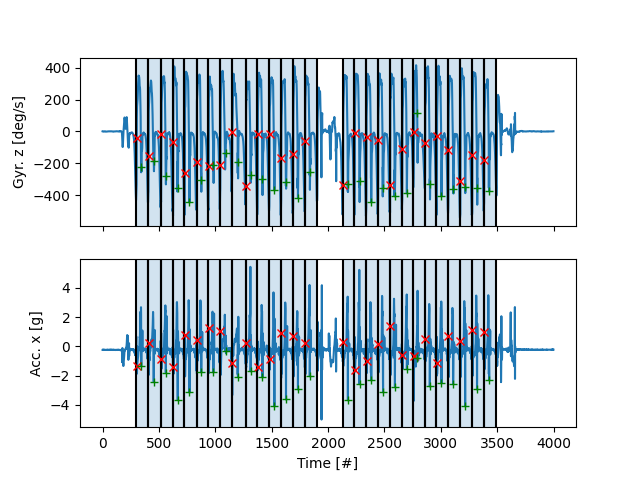

In [11]:
# Plot the gyr_z and acc_x acis with the stride borders and all events
### BEGIN SOLUTION
fig, axs = plt.subplots(2, sharex=True)

plot_strides(data['gyr_z'], final_cleaned_stride_list, ax=axs[0])
axs[0].plot(tos, data['gyr_z'].iloc[tos], 'x', c='r' )
axs[0].plot(hss, data['gyr_z'].iloc[hss], '+', c='g' )
axs[0].set_ylabel('Gyr. z [deg/s]')


plot_strides(data['acc_x'], final_cleaned_stride_list, ax=axs[1])
axs[1].plot(tos, data['acc_x'].iloc[tos], 'x', c='r' )
axs[1].plot(hss, data['acc_x'].iloc[hss], '+', c='g' )
axs[1].set_ylabel('Acc. x [g]')
axs[1].set_xlabel('Time [#]')
### END SOLUTION

## Exercise 4.4: The Stride Time and Swing Time

With the strides and all important events detected we can calculate the stride and the swing time in seconds.

a) Create a function that can calculate the mean and std of the stride time/duration from the `final_cleaned_stride_list`.

b) Create a function that can calculate the mean and std of the swing time from the list of HS and TO events.
Remember, the swing time is the duration between the TO and the HS within a single stride


In [12]:
def calc_stride_time(stride_list, sampling_rate):
    """Calculate the stride time.
    
    Args:
        stride_time: 2D array with start and stop index of each stride
        sampling_rate: sampling rate of the signal in HZ
        
    Returns:
        mean_stride_time: mean stride time over all strides
        std_stride_time: stride time std over all strides
    """
    ### BEGIN SOLUTION
    stride_time = np.diff(stride_list, axis=1).flatten().astype(float)
    stride_time /= sampling_rate
    mean_stride_time = np.mean(stride_time)
    std_stride_time = np.std(stride_time)
    ### END SOLUTION
    return mean_stride_time, std_stride_time

In [13]:
def calc_swing_time(tos, hss, sampling_rate):
    """Calculate the stride time.
    
    Args:
        hss: List with all HS events
        tos: List with all TO events
        sampling_rate: sampling rate of the signal in HZ
        
    Returns:
        mean_swing_time: mean swing time over all strides
        std_swing_time: swing time std over all strides
    """
    ### BEGIN SOLUTION
    swing_time = (hss - tos).astype(float)
    swing_time /= sampling_rate
    mean_swing_time = np.mean(swing_time)
    std_swing_time = np.std(swing_time)
    ### END SOLUTION
    return mean_swing_time, std_swing_time

In [14]:
sampling_rate = 102.4

mean_stride_time, std_stride_time = calc_stride_time(final_cleaned_stride_list, sampling_rate)
mean_swing_time, std_swing_time = calc_swing_time(tos, hss, sampling_rate)

print('Stride Time: {:.4} +/- {:.4} s'.format(mean_stride_time, std_stride_time))
print('Swing Time: {:.4} +/- {:.4} s'.format(mean_swing_time, std_swing_time))

Stride Time: 1.035 +/- 0.04558 s
Swing Time: 0.4056 +/- 0.03467 s


## Exercise 4.4: Bulk Processing (Optional)

a) Test you entire pipeline with at least one or two other files. Check the output of each step.

b) Create a function that combines all steps into one and just outputs the final metrics.

c) Create a loop over all files in the fata folder and calculate the stride and swing time. Present the final results as a dataframe. Does your pipeline work for all datasets? Investigate potential errors.

### Solution:

c) The pipeline showed in this solution works well for all datasets except one.
The subject behind `99430_right` appears to have a really strong heel strike.
Therefore, the peek detection identifies to wrong peaks.
A more robust method might be required here.

In [15]:
def gait_pipeline(data, sampling_rate):
    ### BEGIN SOLUTION
    stride_borders = find_stride_borders(data)
    strides = np.array(list(zip(stride_borders[:-1], stride_borders[1:])))
    
    cleaned_strides = outlier_removal(strides)
    
    tos = np.array([start + find_to(data.iloc[start: stop]) for start, stop in cleaned_strides])
    hss = np.array([start + find_hs(data.iloc[start: stop]) for start, stop in cleaned_strides])
    
    nan_map = np.isnan(hss)
    hss = hss[~nan_map]
    tos = tos[~nan_map]
    final_cleaned_stride_list = cleaned_strides[~nan_map]
    
    mean_stride_time, std_stride_time = calc_stride_time(final_cleaned_stride_list, sampling_rate)
    mean_swing_time, std_swing_time = calc_swing_time(tos, hss, sampling_rate)
    ### END SOLUTION
    return mean_stride_time, std_stride_time, mean_swing_time, std_swing_time

In [16]:
from pathlib import Path
sampling_rate = 102.4

# Loop over all files in the data folder and store all results in a single dataframe
### BEGIN SOLUTION
gait_summary = []
for f in Path('./data').glob('*.csv'):
    data = pd.read_csv(f).set_index('n_samples')
    gait_summary.append([f.stem, *gait_pipeline(data, sampling_rate)])

gait_summary = pd.DataFrame(gait_summary)
gait_summary.columns = ['name', 'mean_stride_time', 'std_stride_time', 'mean_swing_time', 'std_swing_time']
gait_summary = gait_summary.set_index('name')
### END SOLUTION
gait_summary

/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9

,mean_stride_time,std_stride_time,mean_swing_time,std_swing_time
name,,,,
7e1c3_right,1.105143,0.033316,0.394287,0.022695
87b6d_right,1.035156,0.045581,0.405622,0.034673
ac73f_right,1.113281,0.000000,0.419922,0.000000
99430_right,NaN,NaN,NaN,NaN
3b4fa_right,1.098845,0.061889,0.408033,0.030334
bce6e_right,1.069754,0.024743,0.410714,0.014754


## Exercise 4.6: Practical considerations

a) What assumptions did we make at every step of the pipeline?

b) Considering these assumptions, what problems might occur, if we would use the pipeline to analyze unsupervised full-day recordings of a subject?

c) How can we test/ensure that our pipeline does work correctly on all datasets and not just the once we used to develop it?

### Solution:

a) Every analysis measurement and analysis will depend on a lot of assumptions.
 It is important to be aware of these assumptions to pinpoint potential issues.

 In the following a list of some assumptions for this experiment:

 Gait Segmentation
 
- The sensor was attached correctly
- The sensor was correctly configured and measured all data correctly
- The data contained just walking
- The subject does not have severely pathological gait

Outlier Removal

- The walking speed was not changed
- Most strides were detected correctly

Event Detection
 
- The swing phase is <50% of the stride time
- The subject is performing proper heel strikes

b) The provided pipeline will not work well on unsupervised recordings, because it can not differentiate gait from other activities that produce similar peaks in the IMU signal.
For such cases, one could use an activity recognition algorithm first and then only analyze the gait section with our pipeline.

c) You always develop an algorithm based on some test data.
You make sure that the algorithm performs well on this data by tuning some parameters.
However, it is impossible to say, if it will work well on any other dataset.
And if you deal with large amount of data, you can not check and adapt your algorithm for every dataset.
Therefore, you need some way to gain the confidence that your algorithm will work well on unseen data.
We want that our algorithm is able to generalize!

One way to gain some confidence, is to split all the data you have for developing your algorithm into *train* and *test* data.
You develop your algorithm based on your test data and never look at the training data until the very end.
Then you test your developed algorithm on this test data and if it works well, you can be somewhat confident that the algorithm will also perform well on other data in the future.

However, if you adapt the parameters manual you can only do this once with the same test data (if you are really strict).
Once you seen the test data, you are biased.